# Introduction: Rental Housing in San Francisco

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">
    
1. [Problem and Discussion](#0)<br>
    <!-- * Introduction where you discuss the business problem and who would be interested in this project. -->
2. [Description of Data and How it will be Used](#1)<br>   
    <!-- * Data where you describe the data that will be used to solve the problem and the source of the data. -->
3. [Methodology Section](#2)<br>
    <!-- * Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.<br> -->
3.1 [Exploring Datasets with *p*andas](#3)<br>
3.2 [Downloading and Prepping Data](#4)<br>
3.3 [Map with Markers](#5) <br>
3.4 [Choropleth Maps](#6) <br><br>
5. [Results Section](#9) <br>
    <!-- * Results section where you discuss the results. -->
6. [Discussion and Observations](#10) <br>
    <!-- * Discussion section where you discuss any observations you noted and any recommendations you can make based on the results. -->
7. [Conclusion](#11) <br>
    <!-- * Conclusion section where you conclude the report. -->
</div>
<hr>

# 1. Problem and Discussion<a id="0"></a>

Often relocation is a time consuming process. Finding affordable housing with safe neighborhoods and prefered venues is a big challenge.  Data science can save time for finding and meeting such criteria by providing interactive visual tools through Jupyter notebook.  A Goal of this project is to provide such a sample in San Francisco utilizing  **Folium** library to make visual segmentation and clustering data in a map.  This notebook allows users to tweek few parameters and shows crime rate in neighborhoods, rental price ranges and venues on interactive maps.<br><br>
This project can help rentees considering moving to San Francisco or renters deciding reasonable rents since interactive visual aids can quickly allow users to see intuitive and interactive visual infromation. The use of FourSquare data and mapping techniques combined with data analysis will help providing clustered venues along with rents and crime rate in a single map. Lastly, this project is a good practical case toward the development of Data Science skills.<br>

# 2. Dicription of Data and How it will be Used<a id="1"></a>
<br>

In this jupyter notebook, main focal area is set to San Francisco.  This notebook will use geojson data from DataSF (https://data.sfgov.org/api/geospatial/pty2-tcw4?method=export&format=GeoJSON) for geographical information and police department incident report from DataSF (https://data.sfgov.org/api/views/wg3w-h783/rows.csv?accessType=DOWNLOAD) for crime statistics and finally use python-craigslist to retrieve set of most recent posts on interactive map.  The raw data from craigslist is programatically scraped.  The data will generate statistics and interactive visual aids for users.<br><br>
Use Foursquare and geopy data to map top 10 venues for all San Francisco neighborhoods and clustered in groups ( as per Course LAB). Use foursquare and geopy data to map the location of available rental housings and crime rates, separately and on top of the above clustered map in order to identify the venues.  The markers of rental housing display the rents and URL to the posts in the popups. Alternatively Boxplot and Choropleth Maps shows rents statistics and average rents respectively to give a general price trend in the neighborhoods. 

# 3.1 Exploring Datasets with *pandas* and Matplotlib<a id="3"></a>

Datasets: 

1. San Francisco Police Department Incidents from the year 2018 to present - [Police Department Incidents](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783) from San Francisco public data portal. Incidents derived from San Francisco Police Department (SFPD) Crime Incident Reporting system. Updated daily, showing data for the 2018 to current.

2. San Francisco Neighborhoods - [San Francisco Neighborhoods](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4) from San Francisco public data portal. Neighborhood boundaries that were defined in 2006 by the Mayor's Office of Neighborhood Services for use with the SF Find tool: [SF Planning](http://propertymap.sfplanning.org/?name=sffind). All boundaries are for the purpose of defining general locations of neighborhoods for the SF FIND application only, and as such they are not "hard" lines of demarcation

# 3.2 Downloading and Prepping Data <a id="4"></a>

In [115]:
!pip install wget
!wget -q -O 'SF_Find_Neighborhoods.geojson' https://data.sfgov.org/api/geospatial/pty2-tcw4?method=export&format=GeoJSON
!wget -q -O 'Police_Department_Incident_Reports__2018_to_Present.csv' https://data.sfgov.org/api/views/wg3w-h783/rows.csv?accessType=DOWNLOAD

Invalid drive specification.


'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


Import Primary Modules:

In [116]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium # map rendering library

# !conda install -c conda-forge lxml --yes
!pip install lxml
!pip install python-craigslist --upgrade

print('Libraries imported.')

Requirement already up-to-date: python-craigslist in c:\users\haruf\anaconda3\lib\site-packages (1.0.8)
Libraries imported.


# 3.3 Maps with Markers <a id="5"></a>


Let's download and import the data on police department incidents using *pandas* `read_csv()` method.

Download the dataset and read it into a *pandas* dataframe:
Then drop raws which miss essential data.

In [118]:
df_incidents = pd.read_csv('Police_Department_Incident_Reports__2018_to_Present.csv')
print('Dataset downloaded and read into a pandas dataframe!')

df_incidents.rename(columns={'Incident Category':'Category','Analysis Neighborhood':'Neighborhood'},inplace=True)

rows = df_incidents[( pd.isna(df_incidents.Neighborhood))].index
df_incidents.drop(rows, inplace=True)
print(df_incidents.shape)
df_incidents.head()

Dataset downloaded and read into a pandas dataframe!
(307738, 36)


Incident Datetime Incident Date Incident Time  Incident Year  \
0  2020/02/03 02:45:00 PM    2020/02/03         14:45           2020   
1  2020/02/03 03:45:00 AM    2020/02/03         03:45           2020   
2  2020/02/03 10:00:00 AM    2020/02/03         10:00           2020   
4  2020/01/05 12:00:00 AM    2020/01/05         00:00           2020   
5  2020/02/03 08:36:00 AM    2020/02/03         08:36           2020   

  Incident Day of Week         Report Datetime       Row ID  Incident ID  \
0               Monday  2020/02/03 05:50:00 PM  89881675000       898816   
1               Monday  2020/02/03 03:45:00 AM  89860711012       898607   
2               Monday  2020/02/03 10:06:00 AM  89867264015       898672   
4               Sunday  2020/02/03 04:09:00 PM  89877368020       898773   
5               Monday  2020/02/03 08:36:00 AM  89876268020       898762   

   Incident Number   CAD Number Report Type Code Report Type Description  \
0        200085557  200342870.0               II                 Initial   
1        200083749  200340316.0               II                 Initial   
2        200084060  200340808.0               II                 Initial   
4        200085193  200342341.0               II                 Initial   
5        200083909  200340826.0               II                 Initial   

  Filed Online  Incident Code                     Category  \
0          NaN          75000               Missing Person   
1          NaN          11012              Stolen Property   
2          NaN          64015                 Non-Criminal   
4          NaN          68020  Miscellaneous Investigation   
5          NaN          68020  Miscellaneous Investigation   

          Incident Subcategory  \
0               Missing Person   
1              Stolen Property   
2                        Other   
4  Miscellaneous Investigation   
5  Miscellaneous Investigation   

                                Incident Description            Resolution  \
0                                       Found Person        Open or Active   
1  Stolen Property, Possession with Knowledge, Re...  Cite or Arrest Adult   
2                 Aided Case, Injured or Sick Person        Open or Active   
4                        Miscellaneous Investigation        Open or Active   
5                        Miscellaneous Investigation        Open or Active   

              Intersection         CNN Police District  \
0    20TH AVE \ WINSTON DR  33719000.0         Taraval   
1    24TH ST \ SHOTWELL ST  24064000.0         Mission   
2    MARKET ST \ POWELL ST  34016000.0      Tenderloin   
4  PINE ST \ DIVISADERO ST  26643000.0        Richmond   
5    FRONT ST \ JACKSON ST  24697000.0         Central   

                     Neighborhood  Supervisor District   Latitude   Longitude  \
0                       Lakeshore                  7.0  37.726950 -122.476039   
1                         Mission                  9.0  37.752440 -122.415172   
2  Financial District/South Beach                  3.0  37.784560 -122.407337   
4                 Pacific Heights                  2.0  37.787112 -122.440250   
5  Financial District/South Beach                  3.0  37.796926 -122.399508   

                                            point  SF Find Neighborhoods  \
0   POINT (-122.47603947349434 37.72694991292525)                   41.0   
1  POINT (-122.41517229045435 37.752439644389675)                   53.0   
2  POINT (-122.40733704162238 37.784560141211806)                   19.0   
4   POINT (-122.44024995765258 37.78711245591735)                  103.0   
5  POINT (-122.39950750040278 37.796926429317054)                   77.0   

   Current Police Districts  Current Supervisor Districts  \
0                      10.0                           8.0   
1                       3.0                           2.0   
2                       5.0                           3.0   
4                       4.0                           6.0   
5               

Let's find out how many entries there are in our dataset.

In [119]:
df_incidents.shape

(307738, 36)

Find San Francisco coordinate.

In [120]:
address = 'San Francisco, USA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco are 37.7790262, -122.4199061.


Incidents are counted for each neighborhood for displaying the crime rate in the map later.  Load the the latest neighborhood geomery information into data frame to map the crime rate.

In [121]:
# print(df_incidents.head())
df_incidents['Count'] = df_incidents.sum(axis=1)
df_incidents['Count'] = 1
dfc = df_incidents[['Neighborhood','Count']]
df_pd = dfc.groupby(['Neighborhood'],as_index= False).sum()
print(df_pd)

import json # library to handle JSON files

with open('SF_Find_Neighborhoods.geojson') as json_data:
    sf_data = json.load(json_data)
    
neighborhoods_data = sf_data['features']
neighborhoods_data[0]

                      Neighborhood  Count
0            Bayview Hunters Point  17826
1                   Bernal Heights   5316
2              Castro/Upper Market   9299
3                        Chinatown   6239
4                        Excelsior   4869
5   Financial District/South Beach  29070
6                        Glen Park   1531
7                 Golden Gate Park   3379
8                   Haight Ashbury   5193
9                     Hayes Valley   8396
10                  Inner Richmond   4091
11                    Inner Sunset   3646
12                       Japantown   3354
13                       Lakeshore   3729
14                    Lincoln Park    395
15               Lone Mountain/USF   3728
16                          Marina   7402
17                    McLaren Park    305
18                         Mission  35637
19                     Mission Bay   5272
20                        Nob Hill   8839
21                      Noe Valley   2837
22                     North Beach

{'type': 'Feature',
 'properties': {'link': 'http://en.wikipedia.org/wiki/Sea_Cliff,_San_Francisco,_California',
  'name': 'Seacliff'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-122.49345526799993, 37.78351817100008],
     [-122.49372649999992, 37.78724665100009],
     [-122.49358666699993, 37.78731259500006],
     [-122.49360569399994, 37.78752774600008],
     [-122.49283007399993, 37.787882585000034],
     [-122.4927566799999, 37.78773917700005],
     [-122.48982906399993, 37.789482184000065],
     [-122.48899105699991, 37.78928318700008],
     [-122.4878640209999, 37.78958817900008],
     [-122.48736904899994, 37.78942984100007],
     [-122.48598032899991, 37.79080370600008],
     [-122.48581537399991, 37.79070384600004],
     [-122.48557750799989, 37.790559847000054],
     [-122.4850531269999, 37.79036813300007],
     [-122.4842660519999, 37.789411709000035],
     [-122.48407706799992, 37.78939909400009],
     [-122.4838230019999, 37.78928250300004],
     [-122.48

In [122]:
# Find the centroid of polygons in geojson
def centroid(vertexes):
     _x_list = [vertex [0] for vertex in vertexes]
     _y_list = [vertex [1] for vertex in vertexes]
     _len = len(vertexes)
     _x = sum(_x_list) / _len
     _y = sum(_y_list) / _len
     return(_x, _y)

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [123]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [124]:
for data in neighborhoods_data:
    borough = data['properties']['name'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates'][0][0]
    p = centroid(neighborhood_latlon)
    # print(p)
    neighborhood_lat = p[1]
    neighborhood_lon = p[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
# neighborhoods[{'Neighborhood', 'Latitude','Longitude'}]
neighborhoods.head()

Borough            Neighborhood   Latitude   Longitude
0                Seacliff                Seacliff  37.787944 -122.487274
1             Lake Street             Lake Street  37.786151 -122.480569
2  Presidio National Park  Presidio National Park  37.799268 -122.467974
3        Presidio Terrace        Presidio Terrace  37.786930 -122.467957
4          Inner Richmond          Inner Richmond  37.781112 -122.468754

Set up credential to retreve venues from 4 squre.

In [125]:
CLIENT_ID = 'YZH5ISDMNB4IAFJC1B3I4I4Q2XJVMP5D4DRRYP5PI3P2SJHI' # your Foursquare ID
CLIENT_SECRET = '2WMSASM4CJJ5IMNE014OQBW1FGL52BVRAE3TU4GSBKLAWR25' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YZH5ISDMNB4IAFJC1B3I4I4Q2XJVMP5D4DRRYP5PI3P2SJHI
CLIENT_SECRET:2WMSASM4CJJ5IMNE014OQBW1FGL52BVRAE3TU4GSBKLAWR25


In [126]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Seacliff are 37.78794365720007, -122.48727411196657.


First, let's create the GET request URL. Name your URL **url**.

In [127]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=YZH5ISDMNB4IAFJC1B3I4I4Q2XJVMP5D4DRRYP5PI3P2SJHI&client_secret=2WMSASM4CJJ5IMNE014OQBW1FGL52BVRAE3TU4GSBKLAWR25&v=20180605&ll=37.78794365720007,-122.48727411196657&radius=500&limit=100'

In [128]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
results = requests.get(url).json()
# results

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

Now that we have the GeoJSON file, let's create a San Francisco map, centered around **[0, 0]** *latitude* and *longitude* values, with an intial zoom level of 2, and using *Mapbox Bright* style.

In [129]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [130]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name    categories        lat         lng
0                      Seacliff  Neighborhood  37.788259 -122.486401
1                   China Beach         Beach  37.788090 -122.491186
2         Rochambeau Playground    Playground  37.784892 -122.484309
3  Tal-Y-Tara Tea & Polo Shoppe      Tea Room  37.783710 -122.486750

In [131]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


#### Let's create a function to repeat the same process to all the neighborhoods in San Francisco

In [132]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [133]:
sf_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

sf_venues.head()

Seacliff
Lake Street
Presidio National Park
Presidio Terrace
Inner Richmond
Sutro Heights
Lincoln Park / Ft. Miley
Outer Richmond
Golden Gate Park
Presidio Heights
Laurel Heights / Jordan Park
Lone Mountain
Anza Vista
Cow Hollow
Union Street
Nob Hill
Marina
Telegraph Hill
Downtown / Union Square
Tenderloin
Civic Center
Hayes Valley
Alamo Square
Panhandle
Haight Ashbury
Lower Haight
Mint Hill
Duboce Triangle
Cole Valley
Rincon Hill
South Beach
South of Market
Showplace Square
Mission Bay
Yerba Buena Island
Treasure Island
Mission Dolores
Castro
Outer Sunset
Parkside
Stonestown
Parkmerced
Lakeshore
Golden Gate Heights
Forest Hill
West Portal
Clarendon Heights
Midtown Terrace
Laguna Honda
Lower Nob Hill
Upper Market
Dolores Heights
Mission
Potrero Hill
Dogpatch
Central Waterfront
Diamond Heights
Crocker Amazon
Fairmount
Peralta Heights
Holly Park
Merced Manor
Balboa Terrace
Ingleside
Merced Heights
Outer Mission
Ingleside Terraces
Mt. Davidson Manor
Monterey Heights
Westwood Highlands
Wes

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Seacliff              37.787944             -122.487274   
1     Seacliff              37.787944             -122.487274   
2     Seacliff              37.787944             -122.487274   
3     Seacliff              37.787944             -122.487274   
4  Lake Street              37.786151             -122.480569   

                          Venue  Venue Latitude  Venue Longitude  \
0                      Seacliff       37.788259      -122.486401   
1                   China Beach       37.788090      -122.491186   
2         Rochambeau Playground       37.784892      -122.484309   
3  Tal-Y-Tara Tea & Polo Shoppe       37.783710      -122.486750   
4                  Pizzetta 211       37.783694      -122.482879   

  Venue Category  
0   Neighborhood  
1          Beach  
2     Playground  
3       Tea Room  
4    Pizza Place

In [134]:
print(sf_venues.shape)
sf_venues.head()

(4561, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Seacliff              37.787944             -122.487274   
1     Seacliff              37.787944             -122.487274   
2     Seacliff              37.787944             -122.487274   
3     Seacliff              37.787944             -122.487274   
4  Lake Street              37.786151             -122.480569   

                          Venue  Venue Latitude  Venue Longitude  \
0                      Seacliff       37.788259      -122.486401   
1                   China Beach       37.788090      -122.491186   
2         Rochambeau Playground       37.784892      -122.484309   
3  Tal-Y-Tara Tea & Polo Shoppe       37.783710      -122.486750   
4                  Pizzetta 211       37.783694      -122.482879   

  Venue Category  
0   Neighborhood  
1          Beach  
2     Playground  
3       Tea Room  
4    Pizza Place

Let's check how many venues were returned for each neighborhood

In [135]:
sf_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                                  
Alamo Square                                     72                      72   
Anza Vista                                       18                      18   
Apparel City                                     31                      31   
Aquatic Park / Ft. Mason                         71                      71   
Ashbury Heights                                  42                      42   
Balboa Terrace                                   10                      10   
Bayview                                          24                      24   
Bernal Heights                                   58                      58   
Bret Harte                                        5                       5   
Buena Vista                                      16                      16   
Candlestick Point SRA                            11                      11   
Castro                                          100                     100   
Cathedral Hill                                   67                      67   
Cayuga                                           25                      25   
Central Waterfront                                4                       4   
Chinatown                                       100                     100   
Civic Center                                    100                     100   
Clarendon Heights                                19                      19   
Cole Valley                                      60                      60   
Corona Heights                                   39                      39   
Cow Hollow                                       37                      37   
Crocker Amazon                                   17                      17   
Diamond Heights                                  12                      12   
Dogpatch                                         57                      57   
Dolores Heights                                  23                      23   
Downtown / Union Square                         100                     100   
Duboce Triangle                                 100                     100   
Eureka Valley                                    17                      17   
Excelsior                                         4                       4   
Fairmount                                         8                       8   
Financial District                              100                     100   
Fishermans Wharf                                 86                      86   
Forest Hill                                      17                      17   
Forest Knolls                                     7                       7   
Glen Park                                         9                       9   
Golden Gate Heights                               8                       8   
Golden Gate Park                                 15                      15   
Haight Ashbury                                   94                      94   
Hayes Valley                                    100                     100   
Holly Park                                       31                      31   
Hunters Point                                     4                       4   
India Basin                                       3                       3   
Ingleside                                        33                      33   
Ingleside Terraces                               13                      13   
Inner Richmond                                   64                      64   
Inner Sunset                                     57                      57   
Japantown                                        95                      95   
Laguna Honda                                     13                      13   
Lake Street                                      37                      37   
L

#### Let's find out how many unique categories can be curated from all the returned venues

In [136]:
print('There are {} uniques categories.'.format(len(sf_venues['Venue Category'].unique())))

There are 375 uniques categories.


### Analyze Each Neighborhood

In [137]:
# one hot encoding
sf_onehot = pd.get_dummies(sf_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sf_onehot['Neighborhood'] = sf_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sf_onehot.columns[-1]] + list(sf_onehot.columns[:-1])
sf_onehot = sf_onehot[fixed_columns]

sf_onehot.head()

Zoo Exhibit  ATM  Acai House  Accessories Store  Adult Boutique  \
0            0    0           0                  0               0   
1            0    0           0                  0               0   
2            0    0           0                  0               0   
3            0    0           0                  0               0   
4            0    0           0                  0               0   

   Afghan Restaurant  African Restaurant  Alternative Healer  \
0                  0                   0                   0   
1                  0                   0                   0   
2                  0                   0                   0   
3                  0                   0                   0   
4                  0                   0                   0   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0                    0             0       0                       0   
1                    0             0       0                       0   
2                    0             0       0                       0   
3                    0             0       0                       0   
4                    0             0       0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0            0           0                    0                 0   
1            0           0                    0                 0   
2            0           0                    0                 0   
3            0           0                    0                 0   
4            0           0                    0                 0   

   Athletics & Sports  Austrian Restaurant  Auto Garage  Automotive Shop  \
0                   0                    0            0                0   
1                   0                    0            0                0   
2                   0                    0            0                0   
3                   0                    0            0                0   
4                   0                    0            0                0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0           0           0       0     0    0               0   
1          0           0           0       0     0    0               0   
2          0           0           0       0     0    0               0   
3          0           0           0       0     0    0               0   
4          0           0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Bath House  Beach  \
0                 0                 0                   0           0      0   
1                 0                 0                   0           0      1   
2                 0                 0                   0           0      0   
3                 0                 0                   0           0      0   
4                 0                 0                   0           0      0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0                0         0            0           0              0   
1                0         0            0           0              0   
2                0         0            0           0              0   
3                0         0            0           0              0   
4                0         0            0           0              0   

   Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  Board Shop  \
0                         0          0           0       0           0   
1                         0          0           0       0           0   
2                         0          0           0       0           0   
3                         0          0           0       0           0   
4                         0          0           0       0           0   

   Boat or Ferry  Bookstore  Boutique  Bowling Green  Boxing Gym  \
0             

And let's examine the new dataframe size.

In [138]:
sf_onehot.shape

(4561, 375)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [139]:
sf_grouped = sf_onehot.groupby('Neighborhood').mean().reset_index()
sf_grouped

Neighborhood  Zoo Exhibit       ATM  Acai House  \
0                    Alamo Square     0.000000  0.000000        0.00   
1                      Anza Vista     0.000000  0.000000        0.00   
2                    Apparel City     0.000000  0.000000        0.00   
3        Aquatic Park / Ft. Mason     0.000000  0.000000        0.00   
4                 Ashbury Heights     0.000000  0.000000        0.00   
5                  Balboa Terrace     0.000000  0.000000        0.00   
6                         Bayview     0.000000  0.000000        0.00   
7                  Bernal Heights     0.000000  0.000000        0.00   
8                      Bret Harte     0.000000  0.000000        0.00   
9                     Buena Vista     0.000000  0.000000        0.00   
10          Candlestick Point SRA     0.000000  0.000000        0.00   
11                         Castro     0.000000  0.000000        0.00   
12                 Cathedral Hill     0.000000  0.000000        0.00   
13                         Cayuga     0.000000  0.000000        0.00   
14             Central Waterfront     0.000000  0.000000        0.00   
15                      Chinatown     0.000000  0.000000        0.00   
16                   Civic Center     0.000000  0.000000        0.00   
17              Clarendon Heights     0.000000  0.000000        0.00   
18                    Cole Valley     0.000000  0.000000        0.00   
19                 Corona Heights     0.000000  0.000000        0.00   
20                     Cow Hollow     0.000000  0.000000        0.00   
21                 Crocker Amazon     0.000000  0.000000        0.00   
22                Diamond Heights     0.000000  0.000000        0.00   
23                       Dogpatch     0.000000  0.000000        0.00   
24                Dolores Heights     0.000000  0.000000        0.00   
25        Downtown / Union Square     0.000000  0.000000        0.00   
26                Duboce Triangle     0.000000  0.000000        0.00   
27                  Eureka Valley     0.000000  0.000000        0.00   
28                      Excelsior     0.000000  0.000000        0.00   
29                      Fairmount     0.000000  0.000000        0.00   
30             Financial District     0.000000  0.000000        0.01   
31               Fishermans Wharf     0.011628  0.000000        0.00   
32                    Forest Hill     0.000000  0.000000        0.00   
33                  Forest Knolls     0.000000  0.000000        0.00   
34                      Glen Park     0.000000  0.000000        0.00   
35            Golden Gate Heights     0.000000  0.000000        0.00   
36               Golden Gate Park     0.000000  0.000000        0.00   
37                 Haight Ashbury     0.000000  0.000000        0.00   
38                   Hayes Valley     0.000000  0.000000        0.00   
39                     Holly Park     0.000000  0.000000        0.00   
40                  Hunters Point     0.000000  0.000000        0.00   
41                    India Basin     0.000000  0.000000        0.00   
42                      Ingleside     0.000000  0.000000        0.00   
43             Ingleside Terraces     0.000000  0.000000        0.00   
44                 Inner Richmond     0.000000  0.000000        0.00   
45                   Inner Sunset     0.000000  0.000000        0.00   
46                      Japantown     0.000000  0.000000        0.00   
47                   Laguna Honda     0.000000  0.000000        0.00   
48                    Lake Street     0.000000  0.000000        0.00   
49                      Lakeshore     0.000000  0.000000        0.00   
50   Laurel Heights / Jordan Park     0.000000  0.000000        0.00   
51       Lincoln Park / Ft. Miley     0.000000  0.000000        0.00   
52               Little Hollywood     0.000000  0.000000        0.00   
53                  Lone Mountain     0.000000  0.000000        0.00   
54                   Lower Haight     0.000000  0.000000     

In [140]:
sf_grouped.shape

(117, 375)

#### Let's print each neighborhood along with the top 5 most common venues

In [141]:
num_top_venues = 5

for hood in sf_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sf_grouped[sf_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alamo Square----
               venue  freq
0                Bar  0.06
1               Park  0.04
2       Liquor Store  0.04
3               Café  0.03
4  Indian Restaurant  0.03


----Anza Vista----
                     venue  freq
0  Health & Beauty Service  0.11
1                     Café  0.11
2             Burger Joint  0.06
3           Cosmetics Shop  0.06
4            Big Box Store  0.06


----Apparel City----
                        venue  freq
0                  Food Truck  0.19
1                   Nightclub  0.06
2         Rental Car Location  0.03
3                 Candy Store  0.03
4  Construction & Landscaping  0.03


----Aquatic Park / Ft. Mason----
            venue  freq
0      Food Truck  0.08
1     Art Gallery  0.06
2  Chocolate Shop  0.06
3            Park  0.04
4  Scenic Lookout  0.04


----Ashbury Heights----
           venue  freq
0           Park  0.07
1          Trail  0.07
2         Garden  0.05
3       Wine Bar  0.05
4  Grocery Store  0.05


----Balboa Ter


----Laguna Honda----
                 venue  freq
0  Japanese Restaurant  0.08
1             Bus Stop  0.08
2       Sandwich Place  0.08
3             Mountain  0.08
4                 Park  0.08


----Lake Street----
                venue  freq
0                Café  0.11
1       Grocery Store  0.08
2          Playground  0.05
3    Sushi Restaurant  0.05
4  Chinese Restaurant  0.05


----Lakeshore----
                 venue  freq
0                 Lake  0.25
1                 Park  0.25
2  American Restaurant  0.25
3          Golf Course  0.25
4          Zoo Exhibit  0.00


----Laurel Heights / Jordan Park----
             venue  freq
0      Coffee Shop  0.11
1             Café  0.06
2         Wine Bar  0.06
3  Thai Restaurant  0.06
4   Cosmetics Shop  0.06


----Lincoln Park / Ft. Miley----
      venue  freq
0     Trail  0.25
1  Pharmacy  0.12
2  Bus Stop  0.12
3      Park  0.12
4     Motel  0.06


----Little Hollywood----
                venue  freq
0         Coffee Shop  0.21
1  Li

4  Pedestrian Plaza  0.00


----Sherwood Forest----
                 venue  freq
0                Trail   0.2
1  Monument / Landmark   0.2
2                 Park   0.2
3             Bus Stop   0.2
4             Mountain   0.2


----Showplace Square----
                    venue  freq
0  Furniture / Home Store  0.10
1      Mexican Restaurant  0.04
2             Bus Station  0.04
3                     Gym  0.04
4    Gym / Fitness Center  0.04


----Silver Terrace----
                 venue  freq
0  Rental Car Location   0.2
1          Pet Service   0.2
2         Soccer Field   0.2
3                 Park   0.2
4   Athletics & Sports   0.2


----South Beach----
              venue  freq
0    Sandwich Place  0.07
1               Gym  0.04
2       Coffee Shop  0.04
3              Café  0.04
4  Baseball Stadium  0.04


----South of Market----
          venue  freq
0     Nightclub  0.06
1   Coffee Shop  0.05
2   Art Gallery  0.05
3       Gay Bar  0.04
4  Cocktail Bar  0.04


----St. Francis Wo

First, let's write a function to sort the venues in descending order.

In [142]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [143]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sf_grouped['Neighborhood']

for ind in np.arange(sf_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sf_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue    2nd Most Common Venue  \
0              Alamo Square                   Bar                     Park   
1                Anza Vista                  Café  Health & Beauty Service   
2              Apparel City            Food Truck                Nightclub   
3  Aquatic Park / Ft. Mason            Food Truck              Art Gallery   
4           Ashbury Heights                 Trail                     Park   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0          Liquor Store                 Hotel                  Café   
1                   Pub           Coffee Shop          Burger Joint   
2   Arts & Crafts Store  Outdoor Supply Store        Hardware Store   
3        Chocolate Shop        Scenic Lookout                  Park   
4              Wine Bar           Coffee Shop                Garden   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0             BBQ Joint     Convenience Store    Seafood Restaurant   
1              Bus Line         Big Box Store    Mexican Restaurant   
2  Fast Food Restaurant           Candy Store                Bakery   
3               Theater           Beer Garden             Gift Shop   
4         Grocery Store        Breakfast Spot            Playground   

  9th Most Common Venue 10th Most Common Venue  
0  Ethiopian Restaurant       Sushi Restaurant  
1         Grocery Store         Sandwich Place  
2    Miscellaneous Shop                  Trail  
3         Historic Site                Exhibit  
4       Organic Grocery       Toy / Game Store

Run *k*-means to cluster the neighborhood into 5 clusters.

In [144]:
# set number of clusters
kclusters = 5

sf_grouped_clustering = sf_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [145]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sf_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sf_merged = sf_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

sf_merged.head() # check the last columns!

Borough            Neighborhood   Latitude   Longitude  \
0                Seacliff                Seacliff  37.787944 -122.487274   
1             Lake Street             Lake Street  37.786151 -122.480569   
2  Presidio National Park  Presidio National Park  37.799268 -122.467974   
3        Presidio Terrace        Presidio Terrace  37.786930 -122.467957   
4          Inner Richmond          Inner Richmond  37.781112 -122.468754   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               1              Tea Room                 Beach   
1               1                  Café         Grocery Store   
2               3                 Trail           Art Gallery   
3               1          Intersection                  Park   
4               1    Chinese Restaurant       Thai Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0             Playground           Yoga Studio                  Farm   
1             Playground           Pizza Place    Chinese Restaurant   
2           Tennis Court                Tunnel                  Park   
3              BBQ Joint      Sushi Restaurant    Chinese Restaurant   
4  Vietnamese Restaurant   Japanese Restaurant     Korean Restaurant   

  6th Most Common Venue 7th Most Common Venue     8th Most Common Venue  \
0        Farmers Market  Fast Food Restaurant                     Field   
1      Sushi Restaurant           Yoga Studio  Mediterranean Restaurant   
2         Garden Center      Football Stadium       Filipino Restaurant   
3                Bakery   Japanese Restaurant                      Café   
4                Bakery             BBQ Joint             Grocery Store   

  9th Most Common Venue      10th Most Common Venue  
0   Filipino Restaurant  Financial or Legal Service  
1          Liquor Store              Sandwich Place  
2    Falafel Restaurant           French Restaurant  
3       Thai Restaurant                Tennis Court  
4                  Café           Convenience Store

In [146]:
address = 'San Francisco, USA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtown Toronto are 37.7790262, -122.4199061.


Finally, let's visualize the resulting clusters

In [147]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_merged['Latitude'], sf_merged['Longitude'], sf_merged['Neighborhood'], sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [148]:
sf_merged.loc[sf_merged['Cluster Labels'] == 0, sf_merged.columns[[1] + list(range(5, sf_merged.shape[1]))]]

Neighborhood 1st Most Common Venue  2nd Most Common Venue  \
6    Lincoln Park / Ft. Miley                 Trail               Bus Stop   
8            Golden Gate Park                  Park                   Lake   
34         Yerba Buena Island                  Park                    Gym   
42                  Lakeshore           Golf Course                   Park   
44                Forest Hill                  Park                  Trail   
53               Potrero Hill                  Park          Grocery Store   
56            Diamond Heights                 Trail            Coffee Shop   
62             Balboa Terrace    Light Rail Station             Comic Shop   
71              Miraloma Park                  Park             Food Truck   
72               McLaren Park               Dog Run            Golf Course   
74          Visitacion Valley                  Park  Vietnamese Restaurant   
80                  Oceanview           Bus Station                   Park   
86             Silver Terrace                  Park    Rental Car Location   
87                 Bret Harte    Light Rail Station                   Park   
94                  Sunnyside         Deli / Bodega                   Park   
111               Buena Vista                  Park           Tennis Court   
114             Eureka Valley           Yoga Studio                   Park   
116           Sherwood Forest                 Trail                   Park   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
6                    Park              Pharmacy                 Beach   
8               Waterfall               Dog Run      Sculpture Garden   
34                 Island                 Beach        Scenic Lookout   
42    American Restaurant                  Lake     Fondue Restaurant   
44     Light Rail Station     Hotpot Restaurant           Event Space   
53          Deli / Bodega                  Hill        Cosmetics Shop   
56               Bus Line         Grocery Store    Salon / Barbershop   
62               Fountain                  Park          Dessert Shop   
71               Bus Line            Playground         Grocery Store   
72                   Park            Bike Trail        Farmers Market   
74                 Garden     Convenience Store    Mexican Restaurant   
80          Grocery Store                  Food    Spanish Restaurant   
86            Pet Service    Athletics & Sports          Soccer Field   
87               Boutique          Burger Joint          Liquor Store   
94           Dance Studio           Bus Station                 Trail   
111        Scenic Lookout                Museum        Breakfast Spot   
114               Dog Run            Playground   Szechuan Restaurant   
116              Mountain   Monument / Landmark              Bus Stop   

    6th Most Common Venue       7th Most Common Venue 8th Most Common Venue  \
6           Historic Site         American Restaurant                 Motel   
8                    Hill         Monument / Landmark            Playground   
34                  Diner               Boat or Ferry                Tunnel   
42                   Farm              Farmers Market  Fast Food Restaurant   
44      French Restaurant                Tennis Court           Art Gallery   
53      Convenience Store                        Café            Playground   
56               Pharmacy               Shopping Mall               Dog Run   
62           Intersection                         Gym   American Restaurant   
71            Yoga Studio                 Flea Market                  Farm   
72   Fast Food Restaurant                       Field   Filipino Restaurant   
74          Grocery Store                 Flea Market                  Farm   
80             Playground                 Flea Market                  Farm   
86            Yoga Studio  Financial or Legal Service    Falafel Restaurant   
87            Yoga Studio              F

#### Cluster 2

In [149]:
sf_merged.loc[sf_merged['Cluster Labels'] == 1, sf_merged.columns[[1] + list(range(5, sf_merged.shape[1]))]]

Neighborhood            1st Most Common Venue  \
0                        Seacliff                         Tea Room   
1                     Lake Street                             Café   
3                Presidio Terrace                     Intersection   
4                  Inner Richmond               Chinese Restaurant   
5                   Sutro Heights                   Scenic Lookout   
7                  Outer Richmond               Chinese Restaurant   
9                Presidio Heights                       Playground   
10   Laurel Heights / Jordan Park                      Coffee Shop   
11                  Lone Mountain                      Coffee Shop   
12                     Anza Vista                             Café   
13                     Cow Hollow               Italian Restaurant   
14                   Union Street                              Spa   
15                       Nob Hill                            Hotel   
16                         Marina               Italian Restaurant   
17                 Telegraph Hill               Italian Restaurant   
18        Downtown / Union Square                         Boutique   
19                     Tenderloin            Vietnamese Restaurant   
20                   Civic Center                          Theater   
21                   Hayes Valley                         Wine Bar   
22                   Alamo Square                              Bar   
23                      Panhandle                         Boutique   
24                 Haight Ashbury                         Boutique   
25                   Lower Haight                 Sushi Restaurant   
26                      Mint Hill                         Boutique   
27                Duboce Triangle                 Sushi Restaurant   
28                    Cole Valley           Thrift / Vintage Store   
29                    Rincon Hill                      Coffee Shop   
30                    South Beach                   Sandwich Place   
31                South of Market                        Nightclub   
32               Showplace Square           Furniture / Home Store   
33                    Mission Bay                       Food Truck   
35                Treasure Island                       Food Truck   
36                Mission Dolores                      Pizza Place   
37                         Castro                          Gay Bar   
38                   Outer Sunset                      Pizza Place   
39                       Parkside                      Supermarket   
40                     Stonestown                           Bakery   
41                     Parkmerced                              Gym   
45                    West Portal                      Coffee Shop   
48                   Laguna Honda              Japanese Restaurant   
49                 Lower Nob Hill                              Bar   
51                Dolores Heights                             Park   
52                        Mission                             Café   
54                       Dogpatch             Gym / Fitness Center   
55             Central Waterfront               Light Rail Station   
57                 Crocker Amazon                   Baseball Field   
59                Peralta Heights                          Brewery   
60                     Holly Park                           Bakery   
61                   Merced Manor                              Gym   
63                      Ingleside                 Asian Restaurant   
64                 Merced Heights                             Park   
65                  Outer Mission                    Grocery Store   
66             Ingleside Terraces                       Playground   
67             Mt. Davidson Manor                      Yoga Studio   
69             Westwood Highlands                      Yoga Studio   
70                  Westwood Park                 Asian Restaurant   
73                      Sunnyda

#### Cluster 3

In [150]:
sf_merged.loc[sf_merged['Cluster Labels'] == 2, sf_merged.columns[[1] + list(range(5, sf_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
89    Excelsior     Convenience Store            Playground   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
89        Scenic Lookout           Flower Shop            Eye Doctor   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
89    Falafel Restaurant                  Farm        Farmers Market   

   9th Most Common Venue 10th Most Common Venue  
89  Fast Food Restaurant                  Field

#### Cluster 4

In [151]:
sf_merged.loc[sf_merged['Cluster Labels'] == 3, sf_merged.columns[[1] + list(range(5, sf_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
2    Presidio National Park                 Trail           Art Gallery   
43      Golden Gate Heights                 Trail                  Park   
46        Clarendon Heights                 Trail        Scenic Lookout   
47          Midtown Terrace        Scenic Lookout                 Trail   
50             Upper Market                 Trail        Scenic Lookout   
58                Fairmount                 Trail        Scenic Lookout   
68         Monterey Heights              Fountain                Garden   
95                Glen Park                 Trail                  Park   
109       Parnassus Heights                 Trail                  Park   
110           Forest Knolls                 Trail                  Park   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
2            Tennis Court                Tunnel                  Park   
43         Scenic Lookout            Playground           Yoga Studio   
46                 Garden           Art Gallery              Mountain   
47               Mountain           Bus Station           Yoga Studio   
50                   Park              Mountain           Yoga Studio   
58                  Plaza            Playground          Soccer Field   
68                  Trail                  Park        Scenic Lookout   
95         Baseball Field            Playground          Climbing Gym   
109           Salad Place    Chinese Restaurant                Garden   
110              Mountain           Flower Shop    Falafel Restaurant   

    6th Most Common Venue       7th Most Common Venue 8th Most Common Venue  \
2           Garden Center            Football Stadium   Filipino Restaurant   
43            Flea Market          Falafel Restaurant                  Farm   
46              Reservoir                 Tailor Shop                  Park   
47            Flea Market          Falafel Restaurant                  Farm   
50            Flea Market          Falafel Restaurant                  Farm   
58                   Park                     Dog Run           Yoga Studio   
68            Yoga Studio         Filipino Restaurant            Eye Doctor   
95           Tennis Court  Financial or Legal Service    Falafel Restaurant   
109              Mountain          Mexican Restaurant                  Café   
110                  Farm              Farmers Market  Fast Food Restaurant   

    9th Most Common Venue      10th Most Common Venue  
2      Falafel Restaurant           French Restaurant  
43         Farmers Market        Fast Food Restaurant  
46               Bus Stop  Financial or Legal Service  
47         Farmers Market        Fast Food Restaurant  
50         Farmers Market        Fast Food Restaurant  
58    Filipino Restaurant                  Eye Doctor  
68     Falafel Restaurant                        Farm  
95                   Farm              Farmers Market  
109                  Farm              Farmers Market  
110                 Field         Filipino Restaurant

#### Cluster 5

In [152]:
sf_merged.loc[sf_merged['Cluster Labels'] == 4, sf_merged.columns[[1] + list(range(5, sf_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
75  India Basin                  Park         Garden Center   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
75           Yoga Studio     Fondue Restaurant                  Farm   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
75        Farmers Market  Fast Food Restaurant                 Field   

   9th Most Common Venue      10th Most Common Venue  
75   Filipino Restaurant  Financial or Legal Service

# 3.4 Choropleth Maps <a id="6"></a>

Create `Choropleth` maps for crime rate and display clustered venues markers on top. 

In [153]:
#!pip install folium
import folium

sf_geo = r'SF_Find_Neighborhoods.geojson' # geojson file

sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12)

threshold_scale = np.linspace(df_pd['Count'].min(),
                              df_pd['Count'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

sanfran_map.choropleth(
    geo_data=sf_geo,
    data=df_pd,
    columns=['Neighborhood', 'Count'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Crime Rate in San Francisco'
)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_merged['Latitude'], sf_merged['Longitude'], sf_merged['Neighborhood'], sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(sanfran_map)
      
sanfran_map

In [154]:
import re

def findNeighbors(keys, neighbor):
    for key in keys:
        # print('%s in (%s)' % (key.lower(), neighbor.lower()))
        if key.lower() in neighbor.lower():
            return key

Collect craigslist rental posts and scrape the data needed for the later analysis.
Marker's popup lable is constucted here.

In [155]:
!pip install python-craigslist --upgrade

Requirement already up-to-date: python-craigslist in c:\users\haruf\anaconda3\lib\site-packages (1.0.8)


# 5 Results Section <a id="9"></a>

In [156]:
from craigslist import CraigslistHousing
cl_h = CraigslistHousing(site='sfbay', area='sfc', category='sfc/apa',
                         filters={'max_price': 5000, 'min_price': 1000, 
                                  # 'min_bedrooms':1,  'min_bathrooms':1, 'min_ft2': 600, 'private_bath': True, 
                                  'private_room': True})

results = cl_h.get_results(sort_by='newest', geotagged=True, limit=3000)

keys = neighborhoods['Neighborhood'].tolist() 

# define the dataframe columns
column_names = ['Labels', 'Datetime', 'Price', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
houses = pd.DataFrame(columns=column_names)    
        
for result in results:
    # print(result)
    house_price = result['price']
    house_date = result['datetime']
    labels = '(%s) %s: %s' % (result['price'], result['datetime'], result['url'])
   # print(house_name)       
    house_latlon = result['geotag']
    if house_latlon is None: # skip no location data 
        continue
    # print(house_latlon)
    house_lat = house_latlon[0]
    house_lon = house_latlon[1]    
    
    tmp_name = result['where'] 
    if tmp_name is None: # skip no label for neighborhood data
        continue
    house_name = findNeighbors(keys, tmp_name)
    # print(house_name)
    if house_name is None: # skip no label for neighborhood data
        continue
    
    houses = houses.append({'Labels': labels,
                            'Datetime':house_date,
                            'Price': house_price[1:],
                            'Neighborhood': house_name,
                            'Latitude': house_lat,
                            'Longitude': house_lon}, ignore_index=True)
    
houses.head()

# {
#     'id': '7087525506', 
#     'repost_of': None, 
#     'name': '2Bd 1 Ba in 4Bd 2Ba Apartment', 
#     'url': 'https://sfbay.craigslist.org/sfc/roo/d/san-francisco-2bd-1-ba-in-4bd-2ba/7087525506.html', 
#     'datetime': '2020-03-04 20:46', 
#     'last_updated': '2020-03-04 20:46', 
#     'price': '$4000', 
#     'where': 'marina / cow hollow', 
#     'has_image': True, 
#     'geotag': (37.80558, -122.420139)
# }

Request failed (HTTPSConnectionPool(host='sfbay.craigslist.org', port=443): Max retries exceeded with url: /sfc/roo/d/san-francisco-fully-furnished-private/7078507523.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x21F2D3B0>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))). Retrying ...
Request failed (HTTPSConnectionPool(host='sfbay.craigslist.org', port=443): Max retries exceeded with url: /sfc/roo/d/san-francisco-fully-furnished-private/7078507523.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x21F2D3B0>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because con

Labels          Datetime Price  \
0  ($1150) 2020-03-08 09:45: https://sfbay.craigs...  2020-03-08 09:45  1150   
1  ($1615) 2020-03-08 09:39: https://sfbay.craigs...  2020-03-08 09:39  1615   
2  ($1200) 2020-03-08 09:25: https://sfbay.craigs...  2020-03-08 09:25  1200   
3  ($1950) 2020-03-08 09:22: https://sfbay.craigs...  2020-03-08 09:22  1950   
4  ($1484) 2020-03-08 09:21: https://sfbay.craigs...  2020-03-08 09:21  1484   

      Neighborhood   Latitude   Longitude  
0         Parkside  37.733871 -122.495140  
1  Pacific Heights  37.790467 -122.429025  
2     Inner Sunset  37.759549 -122.483292  
3          Mission  37.750900 -122.415300  
4   Telegraph Hill  37.800200 -122.409100

In [157]:
houses.tail()

Labels          Datetime  \
1428  ($1985) 2020-03-01 00:20: https://sfbay.craigs...  2020-03-01 00:20   
1429  ($1130) 2020-03-01 00:14: https://sfbay.craigs...  2020-03-01 00:14   
1430  ($1850) 2020-03-01 00:14: https://sfbay.craigs...  2020-03-01 00:14   
1431  ($1300) 2020-03-01 00:14: https://sfbay.craigs...  2020-03-01 00:14   
1432  ($1480) 2020-03-01 00:14: https://sfbay.craigs...  2020-03-01 00:14   

     Price  Neighborhood   Latitude   Longitude  
1428  1985   South Beach  37.776822 -122.392950  
1429  1130  Inner Sunset  37.751664 -122.474191  
1430  1850      Nob Hill  37.791700 -122.418600  
1431  1300  Inner Sunset  37.751783 -122.473998  
1432  1480  Inner Sunset  37.753724 -122.473011

In [158]:
# Save into csv
houses.to_csv('rent.csv')

In [159]:
houses.dtypes
houses["Price"] = houses["Price"].astype(int) # change data type to int

In [160]:
# houses = pd.read_csv('rent.csv')
houses.tail()

Labels          Datetime  \
1428  ($1985) 2020-03-01 00:20: https://sfbay.craigs...  2020-03-01 00:20   
1429  ($1130) 2020-03-01 00:14: https://sfbay.craigs...  2020-03-01 00:14   
1430  ($1850) 2020-03-01 00:14: https://sfbay.craigs...  2020-03-01 00:14   
1431  ($1300) 2020-03-01 00:14: https://sfbay.craigs...  2020-03-01 00:14   
1432  ($1480) 2020-03-01 00:14: https://sfbay.craigs...  2020-03-01 00:14   

      Price  Neighborhood   Latitude   Longitude  
1428   1985   South Beach  37.776822 -122.392950  
1429   1130  Inner Sunset  37.751664 -122.474191  
1430   1850      Nob Hill  37.791700 -122.418600  
1431   1300  Inner Sunset  37.751783 -122.473998  
1432   1480  Inner Sunset  37.753724 -122.473011

Count how many posts in each neighborhood

In [161]:
dfhm= houses.groupby('Neighborhood',as_index= False).mean()
# dfhm = dfhm.drop(['Count'], axis=1)
houses['Count'] = houses.sum(axis=1)
houses['Count'] = 1
dfhm.tail()

Neighborhood        Price   Latitude   Longitude
33         Stonestown  4500.000000  37.728188 -122.478674
34     Telegraph Hill  1750.100000  37.801042 -122.409162
35         Tenderloin  2275.000000  37.786389 -122.415832
36  Visitacion Valley  1351.666667  37.717368 -122.407574
37   Western Addition  1670.833333  37.780046 -122.433289

In [162]:
dfh = houses[['Neighborhood','Count']]
dfhs= dfh.groupby('Neighborhood',as_index= False).sum()
dfhn = pd.merge(dfhm, dfhs, on='Neighborhood')
dfhn.tail()

Neighborhood        Price   Latitude   Longitude  Count
33         Stonestown  4500.000000  37.728188 -122.478674      1
34     Telegraph Hill  1750.100000  37.801042 -122.409162     40
35         Tenderloin  2275.000000  37.786389 -122.415832      2
36  Visitacion Valley  1351.666667  37.717368 -122.407574      6
37   Western Addition  1670.833333  37.780046 -122.433289      6

Remove all posts outside San Francisco neighborhoods

In [163]:
keys = neighborhoods['Neighborhood'].tolist() 
# print(keys)
# Pick up only SF neighborhoods
dfhf = houses[houses.Neighborhood.str.contains('|'.join(keys), case=False, regex=True)].reset_index(drop=True)
dfhf.tail()

Labels          Datetime  \
1428  ($1985) 2020-03-01 00:20: https://sfbay.craigs...  2020-03-01 00:20   
1429  ($1130) 2020-03-01 00:14: https://sfbay.craigs...  2020-03-01 00:14   
1430  ($1850) 2020-03-01 00:14: https://sfbay.craigs...  2020-03-01 00:14   
1431  ($1300) 2020-03-01 00:14: https://sfbay.craigs...  2020-03-01 00:14   
1432  ($1480) 2020-03-01 00:14: https://sfbay.craigs...  2020-03-01 00:14   

      Price  Neighborhood   Latitude   Longitude  Count  
1428   1985   South Beach  37.776822 -122.392950      1  
1429   1130  Inner Sunset  37.751664 -122.474191      1  
1430   1850      Nob Hill  37.791700 -122.418600      1  
1431   1300  Inner Sunset  37.751783 -122.473998      1  
1432   1480  Inner Sunset  37.753724 -122.473011      1

# 3.6 Distribution and Boxplot of Mean Rents<a id="8"></a>


Rent price statistics

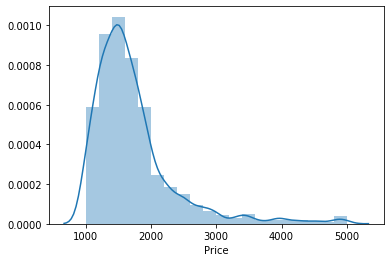

In [164]:
import seaborn as sns
sns.distplot(dfhf['Price'],bins=20)

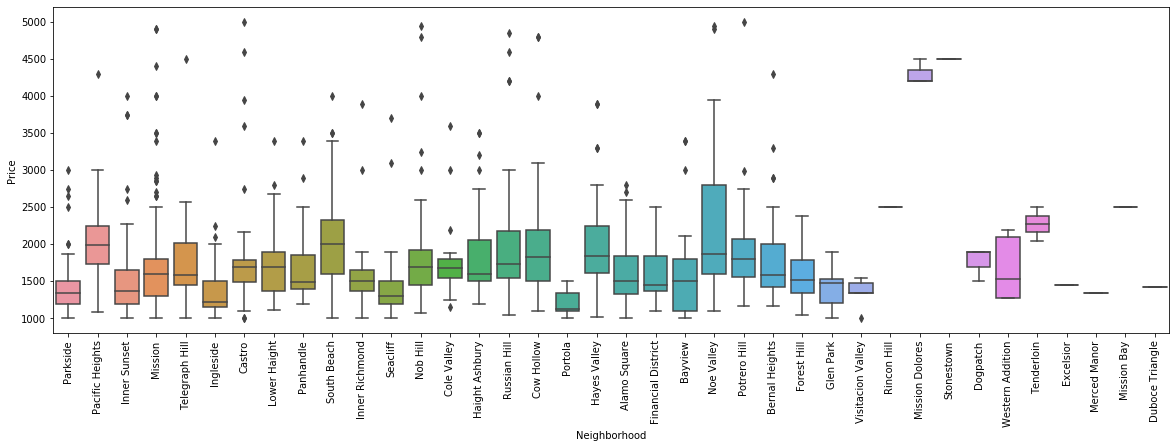

In [165]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
sns.boxplot(x='Neighborhood', y='Price', data=dfhf)

In [166]:
dfha = dfhn[dfhn.Neighborhood.str.contains('|'.join(keys), case=False, regex=True)].reset_index(drop=True)
dfha#.tail()

Neighborhood        Price   Latitude   Longitude  Count
0         Alamo Square  1604.055556  37.775924 -122.440156     54
1              Bayview  1603.030303  37.729786 -122.387759     33
2       Bernal Heights  1818.906250  37.744659 -122.416781     32
3               Castro  1884.418605  37.761963 -122.433881     43
4          Cole Valley  1776.240000  37.767013 -122.447328     25
5           Cow Hollow  1985.614035  37.800200 -122.433610     57
6             Dogpatch  1766.666667  37.762100 -122.397100      3
7      Duboce Triangle  1420.000000  37.758700 -122.433000      1
8            Excelsior  1450.000000  37.725240 -122.417843      1
9   Financial District  1642.187500  37.788288 -122.403611     16
10         Forest Hill  1620.000000  37.734910 -122.463299      4
11           Glen Park  1405.833333  37.732083 -122.440085     18
12      Haight Ashbury  1913.741935  37.770681 -122.445289     31
13        Hayes Valley  2002.583333  37.774693 -122.426819     36
14           Ingleside  1348.297297  37.721247 -122.462604     74
15      Inner Richmond  1580.924528  37.833097 -122.268008     53
16        Inner Sunset  1492.407407  37.754479 -122.473519    108
17        Lower Haight  1751.974359  37.771695 -122.434099     39
18        Merced Manor  1340.000000  37.734388 -122.481130      1
19             Mission  1703.144279  37.747757 -122.422723    201
20         Mission Bay  2500.000000  37.772839 -122.392894      1
21     Mission Dolores  4300.000000  37.758387 -122.423119      3
22            Nob Hill  1909.690909  37.792399 -122.416361     55
23          Noe Valley  2229.411765  37.751128 -122.432090     34
24     Pacific Heights  2020.729167  37.790232 -122.429843     48
25           Panhandle  1686.548387  37.775352 -122.444595     31
26            Parkside  1417.121495  37.749737 -122.490206    107
27             Portola  1217.500000  37.717065 -122.403287     12
28        Potrero Hill  1870.868421  37.759216 -122.397422     38
29         Rincon Hill  2500.000000  37.786400 -122.389200      1
30        Russian Hill  2077.400000  37.870243 -122.153120     40
31            Seacliff  1389.213333  37.778367 -122.487843     75
32         South Beach  2033.941748  37.777731 -122.402309    103
33          Stonestown  4500.000000  37.728188 -122.478674      1
34      Telegraph Hill  1750.100000  37.801042 -122.409162     40
35          Tenderloin  2275.000000  37.786389 -122.415832      2
36   Visitacion Valley  1351.666667  37.717368 -122.407574      6
37    Western Addition  1670.833333  37.780046 -122.433289      6

# 3.7 Mean Rents Distribution in Choropleth Map<a id="9"></a>


Display mean rent price in Choropleth map imposing with a venue marker.

In [167]:
sf_geo = r'SF_Find_Neighborhoods.geojson' # geojson file

sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12)

threshold_scale = np.linspace(dfha['Price'].min(),
                              dfha['Price'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

sanfran_map.choropleth(
    geo_data=sf_geo,
    data=dfha,
    columns=['Neighborhood', 'Price'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='GnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Mean Value for Rent in San Francisco'
)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_merged['Latitude'], sf_merged['Longitude'], sf_merged['Neighborhood'], sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(sanfran_map)
       
sanfran_map

# 4 Latest Available Rents in Choropleth Map with Crime Rate and clustered Venues<a id="10"></a>


Limit the number of posts to 100 in the map

In [168]:
limit = 100 # limit newest posted ads only display in map
newRents = houses.iloc[0:limit, :]

Display the newest 100 craigslist posts and venue type on top of crime rate Choropleth map.

In [169]:
sf_geo = r'SF_Find_Neighborhoods.geojson' # geojson file

sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12)

threshold_scale = np.linspace(df_pd['Count'].min(),
                              df_pd['Count'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

sanfran_map.choropleth(
    geo_data=sf_geo,
    data=df_pd,
    columns=['Neighborhood', 'Count'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Crime Rate in San Francisco'
)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_merged['Latitude'], sf_merged['Longitude'], sf_merged['Neighborhood'], sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(sanfran_map)
      
from folium import plugins
# instantiate a mark cluster object for the incidents in the dataframe
hs = plugins.MarkerCluster().add_to(sanfran_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(newRents.Latitude, newRents.Longitude, newRents.Labels):
    folium.Marker(
        location=[lat, lng],
        icon=folium.Icon(color='green', icon='info-sign'),
        popup=label,
    ).add_to(hs)

# display map
sanfran_map

# 6 Discussion and Observations <a id="10"></a>
    
# 7 Conclusion  <a id="11"></a>

<hr>

Copyright &copy; 2020. This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).